In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import math
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope


# Focus on I02R2V9

In [3]:
# Change path to the files
pwd = '/Users/junyuyao/Desktop/德州奥斯汀/G14 summer/cs data research/JointUrban2003/fast response sf6/TGA/'
os.chdir(pwd)

In [4]:
raw_v4 = pd.read_csv('I02R2V9.CSV', 
                     names=
                        ['Day_of_Year',
                        'UTC_Hours',
                        'UTC_Minutes',
                        'UTC_seconds',
                        'IOP_number',
                        'van_number',
                        'pass_number',
                        'hours_in_CDT_day_start',
                        'latitude',
                        'longitude', 
                        'altitude',
                        'number_of_satellites',
                        'hdop',
                        'concentration_of_SF6',
                         'QC_flag'])
raw_v4 = raw_v4[['hours_in_CDT_day_start','concentration_of_SF6','QC_flag']]
raw_v4['concentration_of_SF6'] = raw_v4['concentration_of_SF6'].apply(lambda x: x+999)
raw_v4

,hours_in_CDT_day_start,concentration_of_SF6,QC_flag
0,11.000000,0.0,5
1,11.000139,0.0,5
2,11.000278,0.0,5
3,11.000417,0.0,5
4,11.000556,0.0,5
...,...,...,...
10796,12.499444,0.0,5
10797,12.499583,0.0,5
10798,12.499722,0.0,5
10799,12.499861,0.0,5


# raw visualization

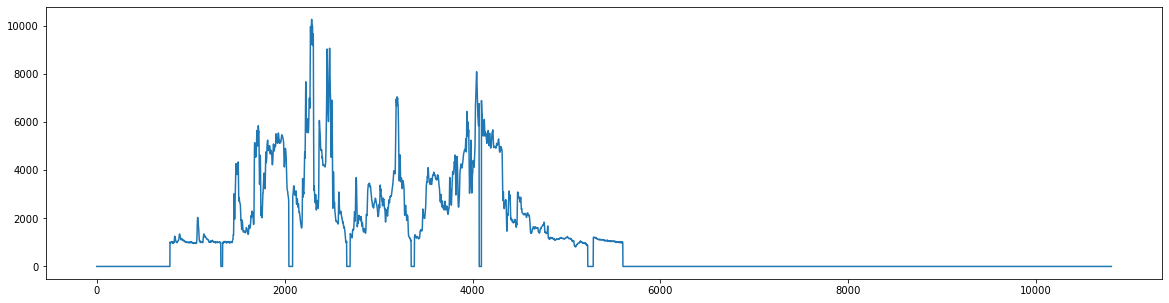

0.0       6196
1008.9       9
1002.1       6
1009.1       6
1107.3       6
          ... 
6856.0       1
6702.1       1
6423.4       1
6080.1       1
1002.3       1
Name: concentration_of_SF6, Length: 3810, dtype: int64
5    5999
0    3416
2     747
1     442
7     197
Name: QC_flag, dtype: int64


In [5]:
plt.figure(figsize=(20,5))
plt.plot(raw_v4[['concentration_of_SF6']])
plt.show()
print(raw_v4['concentration_of_SF6'].value_counts())
print(raw_v4['QC_flag'].value_counts())

# Isolation forest 

In [6]:
raw_v41 = raw_v4.copy()

In [7]:
# reshape data to fit
train = np.array(raw_v41['concentration_of_SF6']).reshape(-1,1)
train

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [8]:
outliers_fraction = float(.005)

In [9]:

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(train) 

IsolationForest(contamination=0.005)

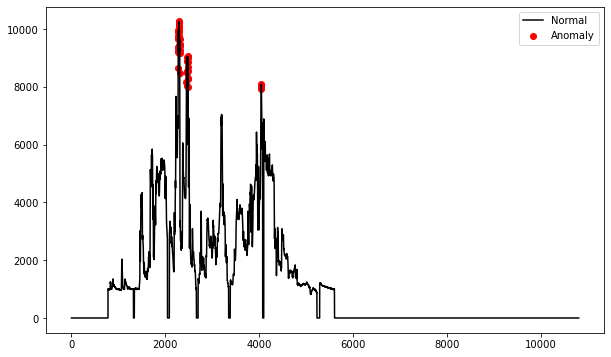

In [10]:
raw_v41['anomaly'] = model.predict(train)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = raw_v41.loc[raw_v41['anomaly'] == -1, ['concentration_of_SF6']] #anomaly

ax.plot(raw_v41.index, raw_v41['concentration_of_SF6'], color='black', label = 'Normal')
ax.scatter(a.index,a['concentration_of_SF6'], color='red', label = 'Anomaly')
plt.legend()
plt.show();


In [11]:
print('Anomaly count: ', np.sum(raw_v41['anomaly']== -1))
raw_v41

Anomaly count:  54


,hours_in_CDT_day_start,concentration_of_SF6,QC_flag,anomaly
0,11.000000,0.0,5,1
1,11.000139,0.0,5,1
2,11.000278,0.0,5,1
3,11.000417,0.0,5,1
4,11.000556,0.0,5,1
...,...,...,...,...
10796,12.499444,0.0,5,1
10797,12.499583,0.0,5,1
10798,12.499722,0.0,5,1
10799,12.499861,0.0,5,1


# clean data base on QC flag and anomaly

In [12]:
raw_v42 = raw_v41.copy()

In [13]:
# Replease unusable data with NaN
raw_v42.loc[
    (raw_v42['QC_flag'] == 4)
     | (raw_v42['QC_flag'] == 6)
     | (raw_v42['QC_flag'] == 7)
     | (raw_v42['QC_flag'] == 9)
     | (raw_v42['QC_flag'] == 10),
    'concentration_of_SF6'
] = math.nan

# Change flags 2 and 5 to 0
raw_v42.loc[
    (raw_v42['QC_flag'] == 2) | (raw_v42['QC_flag'] == 5),
    'concentration_of_SF6'
] = 0

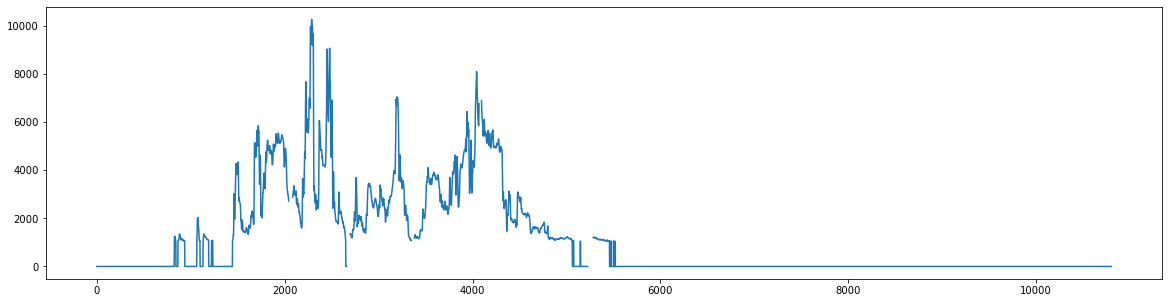

In [14]:
plt.figure(figsize=(20,5))
plt.plot(raw_v42['concentration_of_SF6'])
plt.show()

In [15]:
# Replease anomaly data with NaN
raw_v42.loc[(raw_v42['anomaly'] == -1),'concentration_of_SF6'] = math.nan

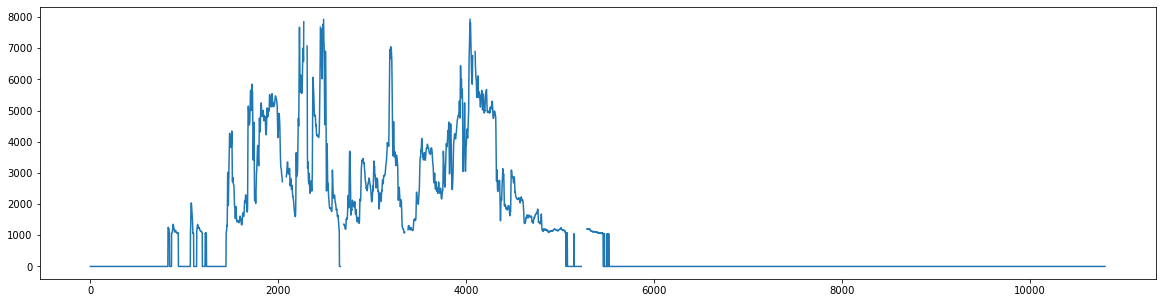

In [16]:
plt.figure(figsize=(20,5))
plt.plot(raw_v42['concentration_of_SF6'])
plt.show()

# Fill null value 

In [17]:
raw_v43 = raw_v42.copy()

In [18]:
raw_v43['ffill'] = raw_v43['concentration_of_SF6'].fillna(method='ffill')
raw_v43['linear_interpolate'] = raw_v43['concentration_of_SF6'].interpolate(method = 'linear')
raw_v43['spline_interpolate'] = raw_v43['concentration_of_SF6'].interpolate(option = 'spline')
raw_v43

,hours_in_CDT_day_start,concentration_of_SF6,QC_flag,anomaly,ffill,linear_interpolate,spline_interpolate
0,11.000000,0.0,5,1,0.0,0.0,0.0
1,11.000139,0.0,5,1,0.0,0.0,0.0
2,11.000278,0.0,5,1,0.0,0.0,0.0
3,11.000417,0.0,5,1,0.0,0.0,0.0
4,11.000556,0.0,5,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10796,12.499444,0.0,5,1,0.0,0.0,0.0
10797,12.499583,0.0,5,1,0.0,0.0,0.0
10798,12.499722,0.0,5,1,0.0,0.0,0.0
10799,12.499861,0.0,5,1,0.0,0.0,0.0


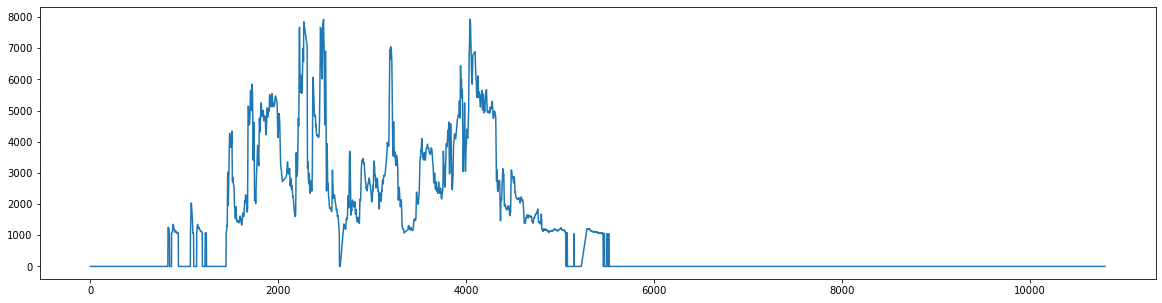

In [19]:
plt.figure(figsize=(20,5))
# plt.plot(raw_v43['concentration_of_SF6'],color = 'green')
# plt.plot(raw_v43['ffill'], color = 'blue')
# plt.plot(raw_v43['linear_interpolate'],color='red')
plt.plot(raw_v43['spline_interpolate'])

plt.show()

# Autoregressive

In [39]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

series = raw_v4['concentration_of_SF6']
X = series.values
# split dataset
train, test = X[1:1000], X[1000:]


Coefficients: [ 1.95432424e+00  1.57795627e+00 -4.18125380e-01 -2.05789055e-01
 -4.50102420e-02  4.08085837e-02  2.45088554e-02  2.51310191e-02
  1.07530675e-02  7.55450020e-03 -3.92107624e-02 -9.18174006e-03
  1.81336094e-02  1.22199997e-02  1.41132220e-02  5.26978194e-03
  4.85602179e-03 -8.96571978e-03  3.20841205e-02 -3.48623152e-01
  5.29839946e-01 -1.79500683e-01 -5.91055768e-02 -2.44141134e-02
  4.53075635e-02  9.07893609e-03 -2.40886739e-02  1.53386034e-02
  2.55980591e-03 -2.35919357e-02 -2.01711249e-02  1.54052298e-02
  8.67811063e-03  1.26684672e-02  1.37487184e-02 -6.88076810e-03
 -2.54265535e-02  9.62552353e-03 -1.01866900e-01  1.95421440e-01
 -6.70624146e-02 -2.35018020e-02 -3.09493910e-02  4.38364865e-02
 -1.11811042e-02  5.69543957e-03 -1.76462649e-03 -1.60378302e-02
 -7.75475532e-03  2.68128575e-03 -2.49745753e-02 -8.05096583e-03
  2.55498143e-02  2.92225701e-02  9.67913631e-03 -1.08524787e-02
 -1.87180345e-02 -2.76770510e-02  8.82608713e-02 -5.69878321e-02
  1.4274046

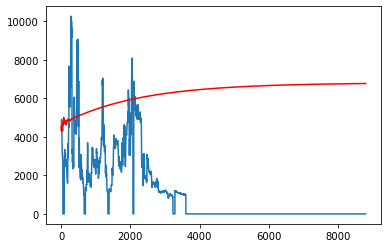

In [55]:
# train autoregression
model = AutoReg(train, lags=100,old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

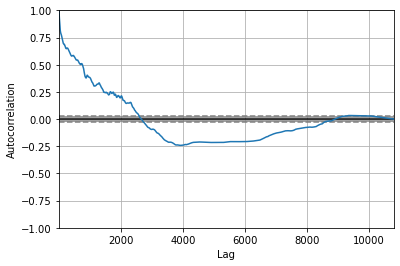

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(X)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10801
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -67089.956
Date:                Mon, 29 Aug 2022   AIC                         134191.912
Time:                        15:56:27   BIC                         134235.636
Sample:                             0   HQIC                        134206.656
                              - 10801                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2141      0.001    222.351      0.000       0.212       0.216
ar.L2          0.1223      0.002     75.724      0.000       0.119       0.125
ar.L3          0.0415      0.004      9.660      0.0

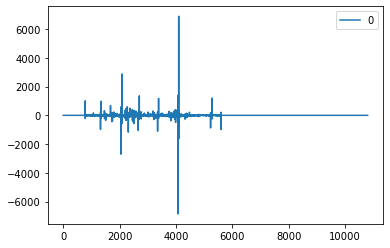

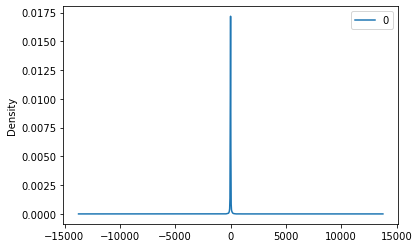

                   0
count   1.080100e+04
mean   -9.381275e-16
std     1.206736e+02
min    -6.857122e+03
25%   -1.734664e-320
50%   -1.734664e-320
75%     0.000000e+00
max     6.891600e+03


In [58]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())